In [1]:
import os
import joblib

import numpy as np
import pandas as pd
from datetime import datetime
import ydata_profiling as yp

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import mlflow
from implicit.als import AlternatingLeastSquares
import psycopg2 as psycopg

import pickle

from catboost import CatBoostClassifier, Pool
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

from dotenv import load_dotenv
import boto3

import warnings
warnings.filterwarnings("ignore")

In [17]:
# Настройка
%matplotlib inline

# Директория

In [25]:
RANDOM_STATE = 36
# Пути и названия файлов заданы в виде параметров
PATH_DATA = '../data'

PATH_MODELS = '../models'
MODEL_FILE = 'model.pkl'

ASSETS_DIR = '../data/asserts'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'project_final_one'
REGISTRY_MODEL_NAME = "ranking_model"

In [26]:
load_dotenv()

os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["S3_BUCKET_NAME"] = os.getenv("S3_BUCKET_NAME") 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

# Рекомендация

## ТОП позиций

In [27]:
# Загрузка данных
events_train = pd.read_csv(f'{PATH_DATA}/events_train.csv', index_col=False)
events_test = pd.read_csv(f'{PATH_DATA}/events_test.csv', index_col=False)

In [28]:
# Посчитаем количество позиций, которые просматривают уникальные пользователи
item_popularity = events_train \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

# Добавляем информацию о товарах
top_items = item_popularity.sort_values('users', ascending=False).head(50)

In [29]:
# Добавляем ранжирование
top_items['rank'] = range(1, len(top_items) + 1)

In [30]:
# Сохраним результат
top_items.to_parquet("../recommendations/top_popular.parquet", engine='pyarrow')

In [31]:
RUN_NAME = 'exp_top_popular'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

parquet_file_path = "top_popular.parquet"
top_items.to_parquet(parquet_file_path, engine='pyarrow')

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifact(parquet_file_path)

🏃 View run exp_top_popular at: http://127.0.0.1:5000/#/experiments/38/runs/ddbb68b1a18a4ccab4f3a34b62eb60e7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/38


## Персональные

In [32]:
# Загрузим данные
events_train = pd.read_csv(f'{PATH_DATA}/events_train.csv', index_col=False)
events_test = pd.read_csv(f'{PATH_DATA}/events_test.csv', index_col=False)
items = pd.read_csv(f'{PATH_DATA}/items_new.csv', index_col=False)
events = pd.read_csv(f'{PATH_DATA}/events_true.csv')

item_encoder = joblib.load(f'{PATH_DATA}/item_encoder.pkl')
user_encoder = joblib.load(f'{PATH_DATA}/user_encoder.pkl')

In [33]:
events_train['timestamp'] = pd.to_datetime(events_train['timestamp'])
events_test['timestamp'] = pd.to_datetime(events_test['timestamp'])
events['timestamp'] = pd.to_datetime(events['timestamp'])

In [34]:
# Создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8) 

user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 1324468 stored elements and shape (1236032, 417051)>

In [35]:
# Создадим модель ALS
als_model = AlternatingLeastSquares(factors=50, 
                                    iterations=500, 
                                    regularization=0.01, 
                                    random_state=RANDOM_STATE)

# Обучим модель ALS
als_model.fit(user_item_matrix_train)

  0%|          | 0/500 [00:00<?, ?it/s]

In [36]:
# Получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 5

# Получаем списки похожих объектов, используя ранее полученную ALS-модель
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# Преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": [sim_scores[0:] for sim_scores in sim_item_scores]})

In [37]:
# Развернем полученные id похожих товаров
similar_items = similar_items.explode(['sim_item_id_enc', 'score'])

# Приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# Получаем исходные идентификаторы
item_id_map = events_train[['item_id_enc', 'item_id']].drop_duplicates().set_index('item_id_enc')['item_id'].to_dict()
similar_items["item_id_init"] = similar_items["item_id_enc"].map(item_id_map)
similar_items["item_id_sim"] = similar_items["sim_item_id_enc"].map(item_id_map)
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# Убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_init != item_id_sim")

In [38]:
similar_items[similar_items['item_id_init'] == 355908]

,score,item_id_init,item_id_sim
0,0.874207,355908,19855
0,0.864970,355908,195941
0,0.857552,355908,380824
0,0.855210,355908,429319
0,0.848526,355908,176827


In [39]:
# Сохраним результат
similar_items.to_parquet("../recommendations/similar_items.parquet", engine='pyarrow')

In [3]:
similar_it = pd.read_parquet('../recommendations/similar_items.parquet')

In [4]:
similar_it

,score,item_id_init,item_id_sim
0,0.874207,355908,19855
0,0.864970,355908,195941
0,0.857552,355908,380824
0,0.855210,355908,429319
0,0.848526,355908,176827
...,...,...,...
159741,0.886956,236179,237440
159741,0.885256,236179,73340
159741,0.872150,236179,105692
159741,0.869748,236179,344947


In [40]:
RUN_NAME = 'exp_similar_items'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

parquet_file_path = "similar_items.parquet"
similar_items.to_parquet(parquet_file_path, engine='pyarrow')

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifact(parquet_file_path)

🏃 View run exp_similar_items at: http://127.0.0.1:5000/#/experiments/38/runs/37be683619ad4bb1860ec34a4280c21c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/38


## Двухстадийный подход

In [41]:
# Вычтем из последней даты несколько дней (5)
test_days = events_test["timestamp"].max() - pd.Timedelta(days=5)

print(test_days)

2015-09-13 02:59:00


In [42]:
# Задаём точку разбиения
split_date_for_labels = test_days

# Разделим данные
split_date_for_labels_idx = events_test["timestamp"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

# Проверим результат
print(f'Тестовый датасет: {events_test_2.shape}')
print(f'Датасет с взаимодействиями за пять дней: {events_labels.shape}')

Тестовый датасет: (70582, 16)
Датасет с взаимодействиями за пять дней: (701910, 16)


In [43]:
# Посмотрим на датасет
events_labels.head()

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc
0,2015-08-02 05:47:00,1190029,338463,0,1483,561.0,0,6,2,5,0.002932,0,1044942,302447,961,87
1,2015-08-02 05:34:00,1111168,456909,0,64,206.0,0,6,2,5,0.012606,0,975655,408154,42,38
2,2015-08-02 05:54:00,505655,409804,1,1191,61.0,0,6,2,5,0.244210,0,444061,366148,762,13
3,2015-08-02 05:53:00,581285,133215,0,973,20.0,0,6,2,5,0.002345,0,510479,119095,626,5
4,2015-08-02 05:47:00,830739,82281,0,860,1515.0,0,6,2,5,0.006450,0,729273,73539,560,242


In [44]:
# Проверим баланс классов
events_labels.target.value_counts()

target
0    681873
1     20037
Name: count, dtype: int64

In [45]:
# Проверим баланс классов
events_test_2.target.value_counts()

target
0    68573
1     2009
Name: count, dtype: int64

In [46]:
# В кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = events_labels.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# для каждого пользователя оставляем 1 негативный пример
negatives_per_user = 1
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=RANDOM_STATE))
    ]).reset_index(drop=True)

In [47]:
# Проверим сколько данных для положительного таргета
candidates_for_train.target.value_counts()

target
1    20037
0    10181
Name: count, dtype: int64

In [48]:
# Зададим функцию, для расчета пользовательских признаков
def get_user_features(events):
    user_features = events.groupby("user_id").agg(
        item_id_week=("timestamp", lambda x: (x.max()-x.min()).days/7),
        item_viewed=("item_id", "count"),
        rating_avg=("rating", "mean"),
        rating_std=("rating", "std"))
    
    return user_features

In [49]:
# Получим новые признаки
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left").fillna(0)

In [50]:
# Поглядим, что получилось
candidates_for_train.head()

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc,item_id_week,item_viewed,rating_avg,rating_std
0,2015-08-02 05:43:00,1027570,7943,1,398,1323.0,0,6,2,5,0.436236,1,902277,7107,259,209,0.0,0.0,0.0,0.0
1,2015-08-01 19:09:00,395552,75102,1,1135,1329.0,0,5,1,19,0.006157,1,347325,67134,732,212,0.0,0.0,0.0,0.0
2,2015-08-01 18:31:00,1396315,165650,1,624,871.0,0,5,1,18,0.002932,1,1226101,148096,411,136,0.0,0.0,0.0,0.0
3,2015-08-01 18:14:00,548871,339531,1,656,1125.0,0,5,1,18,0.040751,1,481995,303405,430,179,0.0,0.0,0.0,0.0
4,2015-08-01 18:41:00,1119187,311484,0,1117,14.0,0,5,1,18,0.031076,1,982697,278369,719,3,0.0,0.0,0.0,0.0


In [51]:
# Сохранимся
candidates_for_train.to_parquet(f'{PATH_DATA}/candidates_for_train.parquet', engine='pyarrow')

In [52]:
# Объединяем тренировочный и таргетный датафреймы
events_inference = pd.concat([events_train, events_labels])
events_inference.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2429483 entries, 0 to 772491
Data columns (total 16 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   user_id         int64         
 2   item_id         int64         
 3   available       int64         
 4   categoryid      int64         
 5   parentid        float64       
 6   istransaction   int64         
 7   day_of_week     int64         
 8   day             int64         
 9   hour            int64         
 10  rating          float64       
 11  target          int64         
 12  user_id_enc     int64         
 13  item_id_enc     int64         
 14  categoryid_enc  int64         
 15  parentid_enc    int64         
dtypes: datetime64[ns](1), float64(2), int64(13)
memory usage: 315.1 MB


In [53]:
# Оставляем только тех пользователей, которые присуствуют в тестовой выборке
candidates_to_rank = events_inference[events_inference.user_id.isin(events_test_2.user_id.drop_duplicates())]

In [54]:
# Проверяем
candidates_to_rank.head()

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc
55,2015-06-02 05:03:00,1219180,422768,0,1240,1546.0,0,1,2,5,0.003811,0,1070545,377703,798,248
64,2015-06-02 05:31:00,800456,31514,1,844,1458.0,0,1,2,5,0.018176,0,702679,28115,549,230
124,2015-06-02 05:05:00,1118731,350689,1,1634,143.0,0,1,2,5,0.043096,0,982295,313335,1050,31
160,2015-06-02 05:40:00,800456,394254,1,84,1308.0,0,1,2,5,0.011727,0,702679,352270,55,207
252,2015-06-01 21:26:00,968797,407343,0,1173,805.0,0,0,1,21,0.030196,0,850683,363963,752,127


In [55]:
# Получим новые признаки
user_features_for_ranking = get_user_features(events_inference)
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on="user_id", how="left").fillna(0)

In [56]:
# Поглядим, что получлиось
candidates_to_rank[candidates_to_rank['user_id']==557378].head(10)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc,item_id_week,item_viewed,rating_avg,rating_std
8,2015-06-01 15:40:00,557378,24855,0,302,1458.0,0,0,1,15,0.036060,0,489469,22177,199,230,6.0,43,0.016827,0.017994
9,2015-06-01 15:42:00,557378,250658,1,302,1458.0,0,0,1,15,0.006743,0,489469,223957,199,230,6.0,43,0.016827,0.017994
50,2015-06-01 15:39:00,557378,267641,0,302,1458.0,0,0,1,15,0.016124,0,489469,239135,199,230,6.0,43,0.016827,0.017994
51,2015-06-01 15:54:00,557378,74642,1,523,593.0,0,0,1,15,0.003811,0,489469,66727,343,95,6.0,43,0.016827,0.017994
74,2015-06-01 15:43:00,557378,188353,1,302,1458.0,0,0,1,15,0.009088,0,489469,168336,199,230,6.0,43,0.016827,0.017994
117,2015-06-01 15:38:00,557378,445128,1,302,1458.0,0,0,1,15,0.010554,0,489469,397662,199,230,6.0,43,0.016827,0.017994
158,2015-06-01 15:44:00,557378,24855,0,302,1458.0,0,0,1,15,0.036060,1,489469,22177,199,230,6.0,43,0.016827,0.017994
193,2015-06-01 15:37:00,557378,188353,1,302,1458.0,0,0,1,15,0.009088,0,489469,168336,199,230,6.0,43,0.016827,0.017994
196,2015-06-01 15:44:00,557378,24855,0,302,1458.0,0,0,1,15,0.036060,0,489469,22177,199,230,6.0,43,0.016827,0.017994
408,2015-06-02 16:03:00,557378,445912,0,646,1606.0,0,1,2,16,0.003225,0,489469,398370,426,257,6.0,43,0.016827,0.017994


In [57]:
# Сохранимся
candidates_to_rank.to_parquet(f'{PATH_DATA}/candidates_to_rank.parquet', engine='pyarrow')

## CatBoostClassifier (вероятности добавления в корзину)

In [58]:
# Задаём имена колонок c признаками и таргетом
features = ['categoryid_enc','parentid_enc', 'available', 'istransaction', 'day_of_week', 'day', 'hour', 'rating', 'item_id_week', 'item_viewed', 'rating_avg', 'rating_std']
cat_features = ['categoryid_enc', 'parentid_enc', 'available', 'istransaction','day_of_week', 'day', 'hour']
target = ["target"]

In [59]:
train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

In [60]:
# Инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(iterations=3000,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           auto_class_weights='Balanced',
                           verbose=500,
                           random_seed=RANDOM_STATE)

# Обучим модель
cb_model.fit(train_data)

0:	learn: 0.6760619	total: 83.7ms	remaining: 4m 11s
500:	learn: 0.4995498	total: 12.1s	remaining: 1m
1000:	learn: 0.4599263	total: 24.4s	remaining: 48.8s
1500:	learn: 0.4254697	total: 36.8s	remaining: 36.7s
2000:	learn: 0.3950727	total: 50.2s	remaining: 25.1s
2500:	learn: 0.3671823	total: 1m 3s	remaining: 12.6s
2999:	learn: 0.3411719	total: 1m 16s	remaining: 0us


In [61]:
with open(f"{PATH_MODELS}/{MODEL_FILE}", "wb") as f:
    pickle.dump(cb_model, f)

In [62]:
# Создадим датасет для катбуста
inference_data = Pool(data=candidates_to_rank[features], cat_features=cat_features)
# Получим вероятности
predictions = cb_model.predict_proba(inference_data)

# Создадим признак с вероятностями базовой модели
candidates_to_rank["cb_score"] = predictions[:, 1]

In [63]:
# Для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

# Отранжируем рекомендации
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

In [64]:
# Посмотрим на результат
candidates_to_rank[['user_id','item_id','cb_score','rank']].head(10)

,user_id,item_id,cb_score,rank
66239,164,106828,0.438685,1
11550,278,458028,0.438659,1
11683,278,405060,0.208742,2
7397,535,252427,0.525295,1
65937,1014,117431,0.890815,1
64898,1014,53078,0.868202,2
66116,1014,4613,0.860664,3
65034,1014,178797,0.856250,4
65913,1014,342614,0.851846,5
64680,1014,170298,0.851540,6


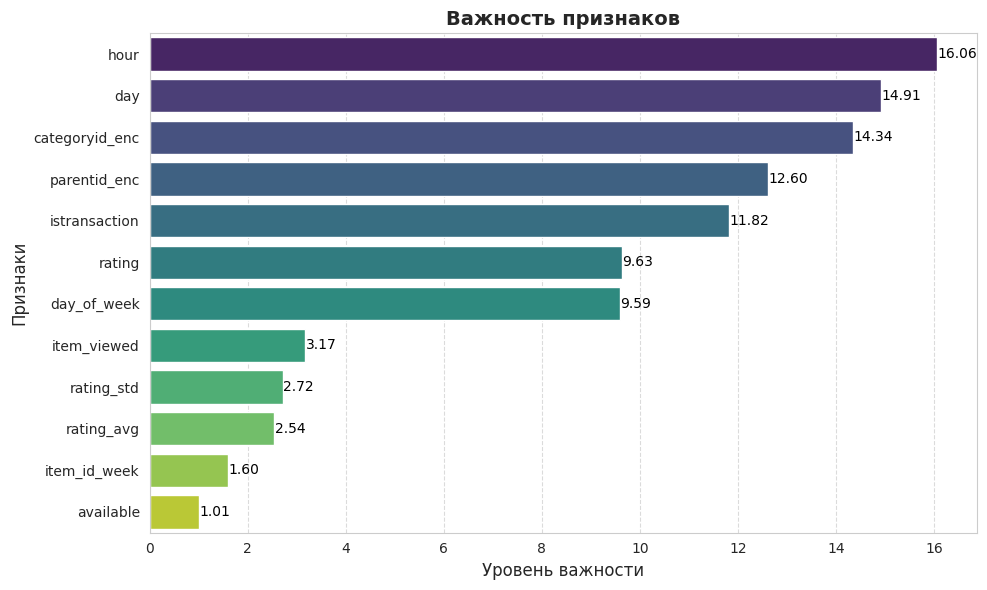

In [65]:
# Создаем серию с важностью признаков
imp = pd.Series(cb_model.feature_importances_, index=features)

# Сортируем значения по убыванию
imp_sorted = imp.sort_values(ascending=False)

# Настройка стиля Seaborn
sns.set_style("whitegrid")

# Создаем график
plt.figure(figsize=(10, 6))
sns.barplot(
    x=imp_sorted.values,
    y=imp_sorted.index,
    palette='viridis',
    edgecolor='white',
    linewidth=1
)

# Добавляем значения важности прямо на график
for i, v in enumerate(imp_sorted.values):
    plt.text(v + 0.01, i, f'{v:.2f}', color='black', ha='left', va='center')

# Настройка оформления
plt.title('Важность признаков', fontsize=14, fontweight='bold')
plt.xlabel('Уровень важности', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Улучшаем сетку
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Сохраняем график
plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'cb_features_important.png'), dpi=300)

# Показываем график
plt.show()

In [66]:
# Сохраним результат с другим названием
recommendations = candidates_to_rank[['user_id','item_id','rank', 'cb_score']].copy()

# Сохраним результат в рекомендации
recommendations.to_parquet("../recommendations/recommendations.parquet", engine='pyarrow')

In [67]:
RUN_NAME = 'exp_final_recs'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(candidates_for_train[features], candidates_to_rank["cb_score"])
input_example = candidates_for_train[features][:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

parquet_file_path = "recommendations.parquet"
recommendations.to_parquet(parquet_file_path, engine='pyarrow')

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_artifacts(ASSETS_DIR)

    model_info = mlflow.catboost.log_model( 
		cb_model=cb_model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)
    
    mlflow.log_artifact(parquet_file_path)

2025/07/04 18:42:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/04 18:42:27 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: 0.115.13, required: fastapi==0.104.1)
 - requests (current: 2.32.4, required: requests==2.31.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/07/04 18:42:27 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - fastapi (current: 0.115.13, required: fastapi==0.104.1)
 - requests (current: 2.32.4, required: requests==2.31.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting envir

🏃 View run exp_final_recs at: http://127.0.0.1:5000/#/experiments/38/runs/d18b16d323c24f6e8fe5d27e12f644b8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/38


# Оценка качества

In [68]:
# Загрузим рекомендации
top_items = pd.read_parquet('../recommendations/top_popular.parquet')
cold_users = pd.read_csv('../data/cold_users.csv', index_col=False)

In [69]:
# Возьмем холодных пользователей для оценки
user_list = list(cold_users['user_id'].unique())

events_cold = events[events['user_id'].isin(user_list)]
events_cold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 679191 entries, 555893 to 2500064
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      679191 non-null  datetime64[ns]
 1   user_id        679191 non-null  int64         
 2   item_id        679191 non-null  int64         
 3   available      679191 non-null  int64         
 4   categoryid     679191 non-null  int64         
 5   parentid       679191 non-null  float64       
 6   istransaction  679191 non-null  int64         
 7   day_of_week    679191 non-null  int64         
 8   day            679191 non-null  int64         
 9   hour           679191 non-null  int64         
 10  rating         679191 non-null  float64       
 11  target         679191 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(9)
memory usage: 67.4 MB


In [70]:
# Посмотрим на данные
events_cold.head()

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target
555893,2015-08-02 05:47:00,1190029,338463,0,1483,561.0,0,6,2,5,0.002932,0
555894,2015-08-02 05:34:00,1111168,456909,0,64,206.0,0,6,2,5,0.012606,0
555895,2015-08-02 05:54:00,505655,409804,1,1191,61.0,0,6,2,5,0.244210,0
555896,2015-08-02 05:53:00,581285,133215,0,973,20.0,0,6,2,5,0.002345,0
555897,2015-08-02 05:47:00,830739,82281,0,860,1515.0,0,6,2,5,0.006450,0


In [71]:
# Напомним, как выглядели рекомендации
top_items.head()

,item_id,users,avg_rating,rank
1861,5411,1686,0.683964,1
127038,370653,1236,0.543242,2
102080,298009,1083,0.481091,3
106110,309778,1033,0.476986,4
115071,335975,999,0.418352,5


In [72]:
# Добавим топ товаров
cold_users_events_with_recs = events_cold.merge(top_items, on="item_id", how="left") 

# Отберем данные, которые удалось получить из рекомендаций без пропусков
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
                 [["user_id", "item_id", "avg_rating"]]

# Отберем данные, где рекомендации не были получены
cold_user_no_recs = cold_users_events_with_recs[cold_user_items_no_avg_rating_idx] \
                  [["user_id", "item_id", "avg_rating"]] 

In [73]:
# Посчитаем покрытие холодных пользователей рекомендациями
cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

coverage_top = cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.97
Среднее покрытие пользователей: 0.83


In [74]:
# Зададим функцию для расчета recall
def calculate_not_null_mean(series: pd.Series) -> float:
    """Вычисляет среднее значение ненулевых значений"""
    return series.notnull().mean()

# Расчитаем среднее количество вхождений популярных товаров для всех юзеров
recall_top_popular = cold_users_events_with_recs.groupby("user_id")["avg_rating"].apply(calculate_not_null_mean).mean()

print(f"Рекомендации топ-50, recall: {recall_top_popular:.5f}")

Рекомендации топ-50, recall: 0.02098


Отвратительный recall, може повезет с рекомендациями

In [75]:
# Загрузим рекомендации
final_recommendations = pd.read_parquet('../recommendations/recommendations.parquet', engine='pyarrow')

In [76]:
final_recommendations

,user_id,item_id,rank,cb_score
66239,164,106828,1,0.438685
11550,278,458028,1,0.438659
11683,278,405060,2,0.208742
7397,535,252427,1,0.525295
65937,1014,117431,1,0.890815
...,...,...,...,...
19029,1407374,241201,13,0.161679
14785,1407374,454301,14,0.115551
10390,1407374,399031,15,0.077262
1107,1407374,459841,16,0.064782


In [77]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    Размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(
        events_train["item_id"].unique()
    )
    ]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], 
        how="outer",
    )    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [78]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    """Расчет precision и recall"""
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # Computing precision
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # Computing recall
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [79]:
final_recommendations

,user_id,item_id,rank,cb_score
66239,164,106828,1,0.438685
11550,278,458028,1,0.438659
11683,278,405060,2,0.208742
7397,535,252427,1,0.525295
65937,1014,117431,1,0.890815
...,...,...,...,...
19029,1407374,241201,13,0.161679
14785,1407374,454301,14,0.115551
10390,1407374,399031,15,0.077262
1107,1407374,459841,16,0.064782


In [80]:
# Метрики для итоговой рекомендаций
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"Итоговые рекомендации, precision: {cb_precision_5:.4f}, recall: {cb_recall_5:.4f}")

Common users: 5605
Итоговые рекомендации, precision: 0.2182, recall: 0.2448


In [81]:
# Расчёт покрытия по объектам
cov_final = final_recommendations['item_id'].nunique() / final_recommendations['user_id'].nunique()

print(f"Итоговые рекомендации, покрытие: {cov_final:.2f}") 

Итоговые рекомендации, покрытие: 4.49


In [82]:
# Разметим каждую рекомендацию признаком viewed
events_train["viewed"] = True

final_recommendations = final_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
final_recommendations["viewed"] = final_recommendations["viewed"].fillna(False).astype("bool")

In [83]:
# Проставим ранги
final_recommendations = final_recommendations.sort_values(by=["user_id", "cb_score"], ascending=[True, False])
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

In [84]:
# Посчитаем novelty по пользователям
novelty_5_final = (1-final_recommendations.query("rank <= 5").groupby("user_id")["viewed"].mean()).mean()

print(f"Novelty@5: {novelty_5_final:.3f}")

Novelty@5: 0.647


In [85]:
# Создадим сводную таблицу по метрикам
popular_metrics = pd.Series([recall_top_popular, coverage_top], index=["recall_top_popular", "coverage"], name="top_popular")


final_recs_metrics = pd.Series([cb_precision_5, cb_recall_5,cov_final,novelty_5_final], 
                               index=["precision_5", "recall_5", "coverage", "novelty_5"],
                               name="final_recs")

metrics_df = pd.concat([popular_metrics, final_recs_metrics], axis=1).fillna(0)

metrics_df

,top_popular,final_recs
recall_top_popular,0.020978,0.000000
coverage,0.825827,4.493845
precision_5,0.000000,0.218210
recall_5,0.000000,0.244841
novelty_5,0.000000,0.647110


In [86]:
json_file_1 = metrics_df['top_popular'].to_json(orient='index')
with open('../data/top_popular_metrics.json', 'w') as f:
    f.write(json_file_1)

# Сохранение второго JSON файла (второй столбец как ключи)
json_file_2 = metrics_df['final_recs'].to_json(orient='index')
with open('../data/final_recs_metrics.json', 'w') as f:
    f.write(json_file_2)

In [87]:
# Теперь создадим словари для логирования
dict1 = metrics_df['top_popular'].to_dict()

# Создание второго словаря (метрики и их значения)
dict2 = metrics_df['final_recs'].to_dict()

In [ ]:
RUN_NAME = 'exp_sys_final_metrics'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(dict1)

🏃 View run rec_sys_final_metrics at: http://127.0.0.1:5000/#/experiments/38/runs/058789a8124047a29b0668118fa32549
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/38


In [89]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(dict2)

🏃 View run rec_sys_final_metrics at: http://127.0.0.1:5000/#/experiments/38/runs/6e4637b6d45641dc965ed1a266d16ad0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/38


# Итог

В связиз с тем, что большенство пользователей данного магазина (~97%) предпочитают просто просматривать товар, рекомендации оставляют желать лучшего. Вполне вероятно, зная свойства товара и имея более длительный промежуток наблюдейний вышло бы получше.